<a href="https://colab.research.google.com/github/HikaruHotta/roadUNet/blob/master/UNetBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Python Modules
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt

from tqdm import trange
from tqdm.notebook import tqdm

from time import sleep

import glob

from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

In [0]:
# constants and paths to our data

IMG_WIDTH, IMG_HEIGHT = 256, 256
NUM_CHANNELS = 3
NEW_IMAGE_SHAPE = (256, 256, 3)
NEW_MASK_SHAPE = (256, 256)

train_path = '/content/drive/Shared drives/CS231n Project/mass_roads_cropped/train'
valid_path = '/content/drive/Shared drives/CS231n Project/mass_roads_cropped/valid'
test_path = '/content/drive/Shared drives/CS231n Project/mass_roads_cropped/test'
model_save_path = '/content/drive/Shared drives/CS231n Project/UNet_0508202.pt'

In [0]:
# define custom dataset class which is interpretable by DataLoader

class CustomDataset():
    def __init__(self, image_paths, target_paths):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.ToTensor()

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index]).convert('L')
        t_image = self.transforms(image)
        t_mask = self.transforms(mask)
        t_mask = t_mask.squeeze()
        return t_image, t_mask

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)

In [0]:
# get all the image and mask path and number of images
def generate_loader(path, batch_size):
  folder_sat = glob.glob(path + "/sat/*.tif")
  folder_map = glob.glob(path + "/map/*.tif")
  len_data = len(folder_sat)
  print(len_data)
  sat_paths = folder_sat
  map_paths = folder_map
  dataset = CustomDataset(sat_paths, map_paths)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  return loader

valid_loader = generate_loader(valid_path, 16)
test_loader = generate_loader(test_path, 1)

350
1225


In [0]:
# https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=3,
        n_classes=1,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [0]:
# training 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, n_classes=2, padding=True).to(device)
optim = torch.optim.Adam(model.parameters())
dataloader = test_loader
epochs = 10

for _ in range(epochs):
    losses = 0
    for X, y in tqdm(dataloader):
        X = X.to(device)  # [N, 3, H, W]
        y = y.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X) # [N, 1, H, W]
        loss = F.cross_entropy(prediction, y.long())
        losses += abs(loss)
        optim.zero_grad()
        loss.backward()
        optim.step()
    print(losses)

# save model
torch.save(model, model_save_path)


tensor(1271.7606, device='cuda:0', grad_fn=<AddBackward0>)



tensor(176.8244, device='cuda:0', grad_fn=<AddBackward0>)



tensor(172.6564, device='cuda:0', grad_fn=<AddBackward0>)



tensor(171.3605, device='cuda:0', grad_fn=<AddBackward0>)



tensor(158.2430, device='cuda:0', grad_fn=<AddBackward0>)



tensor(136.1286, device='cuda:0', grad_fn=<AddBackward0>)



tensor(124.0788, device='cuda:0', grad_fn=<AddBackward0>)



tensor(118.3691, device='cuda:0', grad_fn=<AddBackward0>)



tensor(113.3082, device='cuda:0', grad_fn=<AddBackward0>)



tensor(109.7460, device='cuda:0', grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNetConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNetUpBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# At test time, restart the runtime because cuda runs out of memory
model = torch.load(model_save_path)
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(

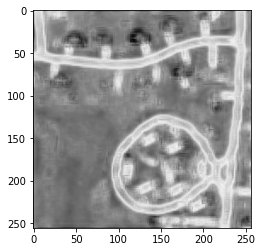

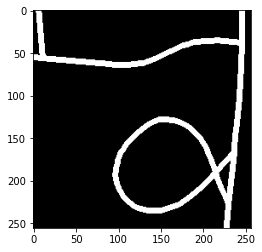

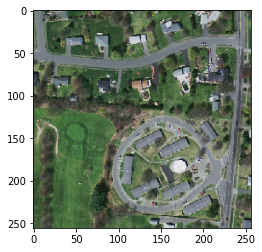

In [0]:
# visualize predictions

# https://github.com/lyft/nuscenes-devkit/blob/master/notebooks/Reference%20Model.ipynb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
counter = 1
for X, y in valid_loader:
    if counter == 2:
        break
    x_copy = X
    pred = model(X.to(device)).detach().cpu().clone().numpy()
    plt.figure(1)
    plt.imshow(pred.transpose(0,2,3,1)[0, :, :, 1], cmap='gray')
    plt.figure(2)
    plt.imshow(y[0], cmap='gray')
    plt.figure(3)
    plt.imshow(x_copy[0].numpy().transpose(1,2,0))
    counter += 1